# MDS & ISOMap for Dimensionality Reduction of Facial Images

---
#### Course: Computational Data Mining
#### Professor: Dr. Fatemeh Shakeri
#### Student: Ilya Khalafi
#### Student ID: 9913039
#### December 2023

# Table Of Contents
- [Introduction](#intro)
- [Dependencies](#dependency)
- [Importing the Dataset](#dataset)
- [Challenges](#challenges)
  - [Implementation of MDS](#mds)
  - [Implementation of Isomap](#isomap)
  - [Applying Isomap on Facial Images](#apply)
- [Visualization & Conclusion](#conclusion)

<a name="intro"></a>

# Introduction 📚

---

One of the important tasks in machine learning is dimensionality reduction, where we try to find and image of our vectors in a subspace without losing their structure. We studied linear dimensionality reduction algorithms such as PCA previously, but linear dimensionality reduction algorithms are not powerful enough in complex and high dimension datasets such manifold shapes.

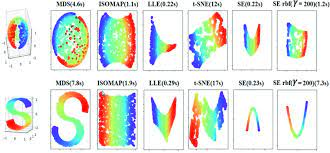

nonlinear dimensionality reduction algorithms are another group of algorithms which apply nonlinear transformations to map the original data points into a subspace. nonlinear transformations are more powerful and they can handle more possibilies in complex-shaped datasets. MDS & ISOMap are two of such algorithms. ISOMap is also based on MDS for torsional shapes.

In this article, we will implement MDS & ISOMap and then apply ISOMap on a dataset of facial images to map them into 2D space, and finally we visualize the result to analyze the performance of ISOMap's mapping.


<a name="dependency"></a>

#Dependencies 🧰

---

We need the following libraries during this article:

- **numpy** : <br />
    numpy is a commonly used library for doing scientific computation. Unlike python default pointer structure, numpy saves variables inplace and continous on RAM and also provides sophisticated methods that use parallelism to make our computations much faster.

- **pandas**: <br />
    pandas is well-known in data science for its useful methods for reading and manipulating the data.

- **scipy**: <br />
    As numpy is specialized for numerical computation, scipy is specialized for scientific computation. It contains several useful methods that are not present inside numpy. We will use it for importing our dataset which is in .mat file. Also we use its implemented method for the floyd-warshal algorithm in Isomap. Keep is mind that floy-warshal is better than the dijkstra's algorithms, because it founds shortest paths between every two nodes in O(V^3) while dijkstra's algorithm requires O(V + E log(V)) ony for finding shortest path between two nodes. And finally, we use the cdist method from scipy library to compute the distance of vectors of facial images. We cannot compute distance with numpy because in order to be fast, we have to use broadcasting but the matrix of facial images is so much big than we cannot make a tensor out it and we will be short in terms of memory, and we cannot use python for loop because it will be very slow and inefficient. Feel free to test it yourself with numpy or for loop.

- **sklearn**: <br />
    sklearn is a well-known data sicence library which has implementation of several classic and modern machine learning methods. We use its NearestNeighbors class and its kneighbors_graph method to implement our Isomap method. Additionally, We use it to test the performance of our implementations for MDS & Isomap.

- **matplotlib**: <br />
    matplotlib is a super useful python library for drawing charts and data visualization. We use it to draw the output of Isomap and facial images.


In [ ]:
%%capture
# Fundamental Data Analysis & Visualization Tools
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.sparse.csgraph import floyd_warshall
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.manifold import MDS, Isomap
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

<a name="dataset"></a>

#Importing the Dataset 🔽

---

Here we download the dataset of facial images from my google drive, then we import it using the pandas library.

In [ ]:
# Downloading the dataset
%%capture
!gdown '1aDX6TlB1qWZ0RozmKQmeWLnRyelvbm93'

Now, we import our dataset using loadmat method from scipy library.

In [ ]:
# Importing the dataset
dataset = loadmat("isomap.mat")
type(dataset)

dict

It seems our dataset is imported as a dictionary, lets print its keys to see its content...

In [ ]:
list( dataset.keys() )

['__header__', '__version__', '__globals__', 'images']

It seems the only useful data is saved in "images" key, which is the dataset of our facial images. Lets keep it and remove other values.

In [ ]:
# Keeping facial images
faces = dataset['images'].astype(float)
# Printing type the faces variable
print('var type: ', type(faces))
# Printing shape of the faces variable if it is a numpy array
if type(faces) == np.ndarray:
    print('shape of the matrix: ', faces.shape)

var type:  <class 'numpy.ndarray'>
shape of the matrix:  (4096, 698)


Perfect! We have imported our dataset which is a numpy 2D array. Each **column** represents a 64x64 flattened image.

<a name="challenges"></a>

#Challenges 🧨

---

Now, in this section, we will solve the following challenges:
- Implementation of MDS
- Implementation of Isomap
- Applying Isomap on Facial Images

<a name="mds"></a>

###Implementation of MDS

---

In order to implement Isomap method, first we need to implement MDS, because Isomap is basically has same procedure as MDS, but it uses geodesic distance of data points to calculate distances instead of using a simple euclidean norm.


In [ ]:
def my_mds(A, k):
    """
    Implementation of the multidimensional scaling (MDS) algorithm based on the class lessons.
    --------------------------------
    A : Distance matrix
    k : Dimension of the mapping subspace
    """
    n = A.shape[0]
    A[~np.isfinite(A)] = 1.0 # Replacing inf with 1
    A[np.isnan(A)] = 0.0 # Replcaing nan with 0
    A_tilda = A ** 2
    L = np.eye(n) - (1/n)
    B = - L @ A_tilda @ L / 2
    eigvals, eigvects = np.linalg.eig(B) # Returned eigenvectors are normalized
    eigvals = np.maximum(eigvals, 0) # Replacing negative eigenvalues with zero

    # Sort eigenvalues and eigenvectors by decreasing order of eigenvalues
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvects = eigvects[:, sorted_indices]

    # Select the top k eigenvectors & eigenvalues
    Q_k = eigvects[:, :k]
    Lambda_k = np.diag(np.sqrt(eigvals[:k]))
    X = np.real( Q_k @ Lambda_k )

    return X

Now, lets text our method with an example from the class...

In [ ]:
# Defining the matrix of original distances
A = np.array([[0,4,4],[4,0,4],[4,4,0]])
# Applying MDS
X = my_mds(A, 2)
# Printing the distance of the returned vectors
np.linalg.norm(X[:, np.newaxis] - X, ord=2, axis=2)

array([[0.        , 3.85921341, 4.14970383],
       [3.85921341, 0.        , 3.98577847],
       [4.14970383, 3.98577847, 0.        ]])

Good enough... our method works properly. Please keep in mind that some inaccuracy is inevitable due to the fact that the problem of finding eigenvalues and eigenvectors is ill-conditioned in general.

<a name="isomap"></a>

###Implementation of Isomap 🌟

---

Next, we implement the Isomap algorithm. This is how it works:

1. Find neighbors of each node using the "method" argument ("knn" or "e-ball)

2. Using the adjacency matrix of the graph, use the Floyd-Warshal algorithm to find the shortest path between each two node (Geodesic distances)
   
3. Apply MDS on the calculated geodesic distances

In [ ]:
def my_isomap(A, sub_dim=2, method="knn", k=-1, eps=1):
  """
  Implementation the Isomap algorithm for dimensionality reduction based on the class lessons.
  --------------------------------
  A(matrix) : Distance matrix
  sub_dim(uint) : Dimension of the mapping subspace
  method(str) : Method to use for finding neighbors of nodes, possible values : "knn", "e-ball"
  k(uint) : Number k for the KNearestNeighbors method
  eps(ufloat) : epsilon for e-ball method
  """
  if method == "knn":
    # Construct the k-nearest neighbors graph
    k = sub_dim + 1 if k <= 0 else k
    knn = NearestNeighbors(n_neighbors=k, metric="precomputed").fit(A)
    adj_mat = knn.kneighbors_graph(A, mode="distance")
    adj_mat[ adj_mat == 0 ] = np.inf

  elif method == "e-ball":
    # Construct the epsilon-ball graph
    # adj_mat = kneighbors_graph(A, n_neighbors=None, mode="distance", include_self=False)
    adj_mat = np.full(A.shape, np.inf)
    adj_mat[A < eps] = A[A < eps]

  else:
    raise ValueError(f"Invalid method: {method}")

  # Compute the geodesic distances between all pairs of points
  # using floyd_warshall_numpy method from scipy.sparse.csgraph
  geodesic_distances = floyd_warshall(adj_mat, directed=False)

  # Apply multidimensional scaling (MDS) to the geodesic distances
  embeddings = my_mds(geodesic_distances, sub_dim)

  return embeddings

I could not find a sample data to test my method, but we have already tested my_mds method and other than that, my_isomap only uses predefined methods from well-known libraries; therefore, we expect everything to be alright.

<a name="apply"></a>

##Applying Isomap

---

Finally, we apply our isomap method on facial images. Additionally, we apply the Isomap method from sklearn library, too. In the next section, we compare and analyze the results of these two methods.

In [ ]:
%%capture
# Calculating the distance matrix of pair of faces
distances = cdist(faces.T, faces.T, 'euclidean')
# Applying Isomap on the matrix of distances
embeddings = my_isomap(distances, sub_dim=2, k=5, method='knn')
embeddings_sklearn = Isomap(n_components=2, n_neighbors=3, metric="precomputed", path_method="FW").fit_transform(distances)

Now, lets plot the 2D embedding points...

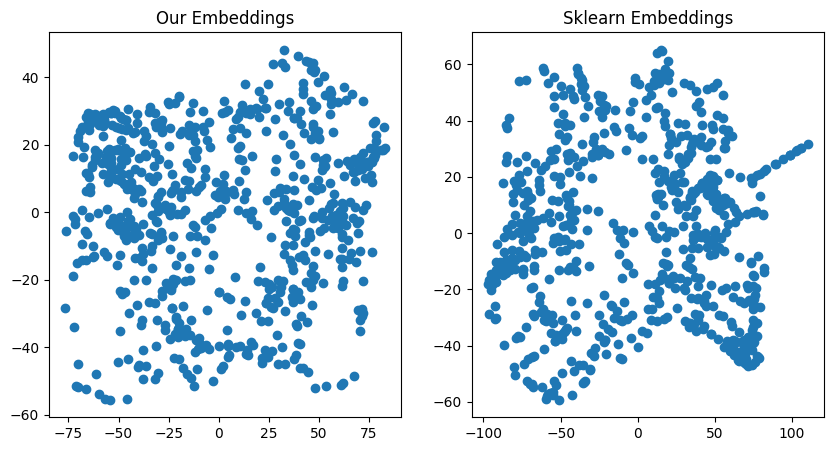

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plotting embeddings from our isomap method
axs[0].set_title("Our Embeddings")
axs[0].scatter(embeddings.T[0], embeddings.T[1])
# Plotting embedding from sklearn's isomap method
axs[1].set_title("Sklearn Embeddings")
axs[1].scatter(embeddings_sklearn.T[0], embeddings_sklearn.T[1])

Awesome! In the next section, we plot facial images near some of the embedding points and also do this task for the output of Isomap method from sklearn library.


<a name="conclusion"></a>

#Visualization & Conclusion 📈

---

In this section, we plot embeddings but put face image of each embedding instead of a simple dot. Before accomplishing this task, we define a function that filters a subset of our embeddings that are not too dense. We define this method because if we plot all faces, it will too dense for us to observe all samples.

In [ ]:
def separate_by_distances(vects, threshold=0.5):
    """ Filters a sparse subset of the original embeddings set
    --------------------------------
    vects : Original set of all embeddings
    threshold : Minimum distance between each two samples of output
    """
    rows = [0]
    for i, vect in enumerate(vects):
        if len(rows) == 0 or np.all( np.linalg.norm(vects[rows] - vect, ord=2, axis=1) > threshold):
            rows.append(i)
    return rows

Finally, plot our embeddings and their images...

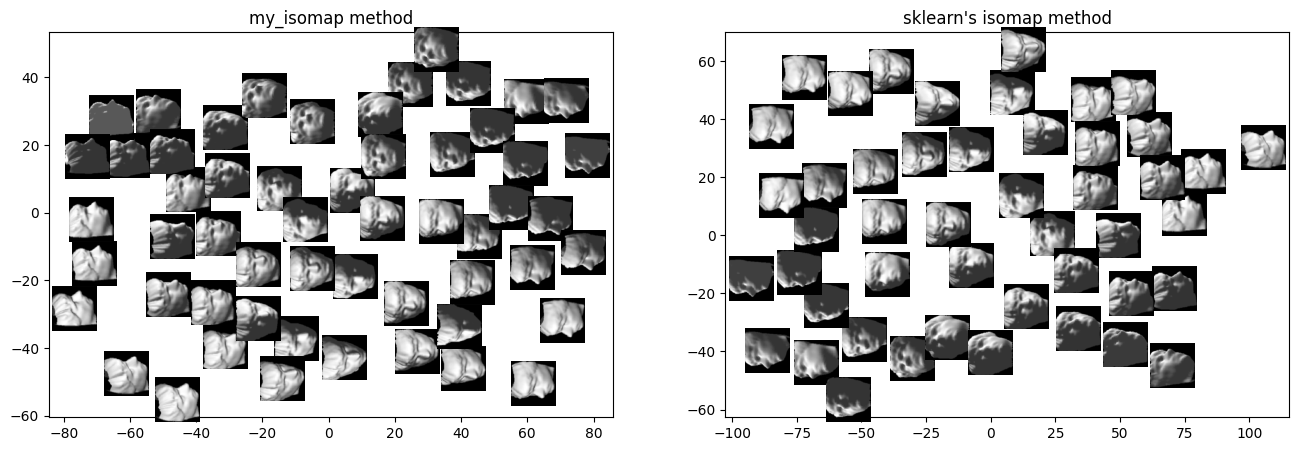

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Sampling a sparse subset of our embeddings
selected = separate_by_distances(embeddings, threshold=12)
x = embeddings[selected].T[0].tolist()
y = embeddings[selected].T[1].tolist()

# Sampling a sparse subset of sklearn embeddings
selected_sklearn = separate_by_distances(embeddings_sklearn, threshold=15)
x_sklearn = embeddings_sklearn[selected_sklearn].T[0].tolist()
y_sklearn = embeddings_sklearn[selected_sklearn].T[1].tolist()

# Plotting points of embeddings, we will add images later...
axs[0].scatter(x, y)
axs[1].scatter(x_sklearn, y_sklearn)

# Adding title for plots...
axs[0].set_title("my_isomap method")
axs[1].set_title("sklearn's isomap method")

# Plotting equivalent images of our embeddings on its reduced coordination
for i, face_num in enumerate(selected):
    img = OffsetImage(faces[:, face_num].reshape((64, 64)), zoom=0.5, cmap='gray')
    ab = AnnotationBbox(img, (x[i], y[i]), frameon=False)
    axs[0].add_artist(ab)

# Plotting equivalent images of sklearn embeddings on its reduced coordination
for i, face_num in enumerate(selected_sklearn):
    img = OffsetImage(faces[:, face_num].reshape((64, 64)), zoom=0.5, cmap='gray')
    ab_sklearn = AnnotationBbox(img, (x_sklearn[i], y_sklearn[i]), frameon=False)
    axs[1].add_artist(ab_sklearn)

Here are our observations:

- Our method embeds images based on horizontal and vertical rotations as well as brightness of faces. The X-axis displays **the horizontal rotation** of faces, while the Y-axis represents a **combination of the vertical rotation and brightness of** faces.

- SKlearn's method also employs a similar format for embedding. The X-axis of SKlearn's embeddings displays **the horizontal rotation** of faces, and the Y-axis shows a **combination of the vertical axis and brightness** of faces. However, in SKlearn's plot, we can observe that brighter images with head-up orientation appear lower on the Y-axis, indicating that **our embeddings' Y-axis is opposite to that of SKlearn's embeddings**.


Thanks for you valuable time and attention! This notebook is available in the link below😀

https://drive.google.com/file/d/1YqGJQ4ROJbiweHE60Qt3v3XRCA73dXQu/view?usp=sharing